## Topic modelling using comments on bitcoin forums

### Part I - Exploration

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords, brown
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.tag import UnigramTagger

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wenlin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wenlin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wenlin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import emoji
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
from pprint import pprint

In [3]:
import logging
import gensim 
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
# logging.basicConfig(level='warning')
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.WARNING)
from wordcloud import WordCloud
import matplotlib.colors as mcolors
import pyLDAvis.gensim
import pyLDAvis

In [4]:
pd.set_option('max_rows', 1000)
pd.set_option('max_colwidth', 2000)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 2000]


In [5]:
posts = pd.read_csv("../Data-collected/splitbytopic.csv", encoding='utf-8')

C:\Python\Python36\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (0,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253

In [7]:
posts.shape

(53382, 1324)

In [6]:
posts.isnull().sum()

Unnamed: 0          58
mark               512
comment            739
Unnamed: 3       52458
Unnamed: 4       52495
                 ...  
Unnamed: 1319    53381
Unnamed: 1320    53381
Unnamed: 1321    53381
Unnamed: 1322    53381
Unnamed: 1323    53381
Length: 1324, dtype: int64

In [7]:
posts = posts[['mark', 'comment']]
posts.fillna('NA', inplace=True) # fills in a few NA cells

In [8]:
posts.head()

mark  \
0                                                                                                                                                                                                                                                                                                                                                                                  2017/1/1/A Bitcoin-Eating Robot   
1                                                                                                                                                                                                                                                                                                                                                                         2017/1/1/Accepting payment unanonymously   
2                                                                                                                                                                                                                                                                                                                                                                 2017/1/1/Bitcoin: Halving on the Horizon {Video}   
3  2017/1/1/Bitcoinmarkets Party Hey guys, I think it's time we organized a Party. Let's have a blast and party like it's Dec 6th 2017. I will be in San Fransisco in March to visit some Bitcoiners, so maybe we organize a Party in Vegas? In April/May I can organize one in Europe. June in Asia? I'll be in Hong Kong for the whole month of June Anyone interested in getting fucked up with some Bitcorners   
4                                                                                                                                                                                                                                                                                                                                            2017/1/1/Downloading Blockchain on External Hard Disk is Recommended!   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [9]:
posts.dropna(axis=0, how='any', inplace=True)

In [10]:
posts.iloc[14,0]

'2017/1/1/[Daily Discussion] Sunday, January 01, 2017 Welcome to the r/BitcoinMarkets daily discussion thread! Thread topics include, but are not limited to: General discussion related to the days events Technical analysis Trading ideas & strategies Questions that do not warrant a separate post Thread Guidelines Be excellent to each other. Please do not create separate posts for the types of discussion mentioned above outside of the daily thread. If you do, your post may be removed and/or heavily downvoted. News that may have a big impact on the market may be posted as a separate thread. Other ways to interact Live chat on BitcoinMarkets IRC Set your flair to participate in the BitcoinMarkets Flair Game (view current standings) Weekly threads - Newbie Mondays and Fundamentals Fridays'

In [ ]:
'''
The daily discussion topics include:
1. General discussion on that day's events
2. Technical analysis
3. Trading ideas and strategies
4. Questions that do not warrant a separate thread

But the daily discussion may not include:
1. News that may have a big impact on the market

This means that topic modelling may not be very fruitful since most discussion topics will likely be captured in the same thread and there's not much point trying to separate posts from each other.

It may be better to see the change in topics over time instead of separating threads over the entire time period.
'''

In [8]:
# There is also a separate altcoin discussion thread that was started in April 2018, for the purpose of discussing other cryptocurrency than bitcoin.
altcoin_df = posts.loc[posts['comment'].str.contains('[Altcoin Discussion]', regex=False)]
altcoin_df.shape # 1326 out of 53,382 posts are altcoin discussions

(1326, 2)

In [10]:
altcoin_df.iloc[200,:]

mark                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [9]:
altcoin_df.head()

mark  \
18007  2017/11/25/MOVED: Ethereum Rising   
21742                         2018/1/5/1   
21779                         2018/1/6/1   
21827                         2018/1/7/1   
21859                         2018/1/8/1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               comment  
18007                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [11]:
# Repeated phrases to remove from post headings
dail_str = ['[Daily Discussion]',
'[Altcoin Discussion]',
'Altcoin Discussion',
'Altcoins Discussion',
'Welcome to the r/BitcoinMarkets daily discussion thread!',
'Thread topics include, but are not limited to',
'General discussion related to the days events',
"General discussion related to the day's events",
'Technical analysis Trading ideas & strategies',
'Technical analysis, Trading ideas & strategies',
'Technical analysis, trading ideas & strategies',
'Questions that do not warrant a separate post',
'Quick questions that do not warrant a separate post',
'Thread Guidelines',
'Thread guidelines',
'Be excellent to each other',
'Please do not create separate posts for the types of discussion mentioned above outside of the daily thread', 
'Do not make posts outside of the daily thread for the topics mentioned above',
'Other ways to interact',
'Get an invite to live chat on our Slack group',
'Set your flair to trade pretend money in the Flair Game',
'Weekly threads: Newbie Mondays and Fundamentals Fridays',
'If you do, your post may be removed and/or heavily downvoted',
'News that may have a big impact on the market may be posted as a separate thread.',
'Live chat on BitcoinMarkets IRC',
'Set your flair to participate in the BitcoinMarkets Flair Game',
'(view current standings)',
'Weekly threads - Newbie Mondays and Fundamentals Fridays',
'Weekly threads: Newbie Mondays and Fundamentals Fridays']

In [12]:
dail_df = posts.loc[posts['comment'].str.contains('[Daily Discussion]', regex=False)]
dail_df.shape # 2,091 out of the 52,510 posts are 'Daily Discussion' or altcoin discussion posts

(2091, 2)

In [13]:
# Remove repeated strings from Daily Discussion posts
for stri in dail_str:
    posts['mark'] = posts['mark'].str.replace(stri, '', regex=False)
    posts['comment'] = posts['comment'].str.replace(stri, '', regex=False)

In [14]:
# Separate date in another column
def get_date(mystring):
  datestring = re.compile('\d{4}/\d{1,2}/\d{1,2}/')
  if datestring.match(mystring):
    return datestring.match(mystring).group()[:-1]
  else:
    return 'null'

posts['date'] = posts['mark'].apply(get_date)

<>:3: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
<ipython-input-14-af8ca00d1530>:3: DeprecationWarning: invalid escape sequence \d
  datestring = re.compile('\d{4}/\d{1,2}/\d{1,2}/')


In [15]:
# Remove date from post title
def remove_date(mystring):
  datestring = re.compile('\d{4}/\d{1,2}/\d{1,2}/')
  if datestring.match(mystring):
    return re.sub(datestring, '', mystring)
  else:
    return mystring

posts['mark'] = posts['mark'].apply(remove_date)

<>:3: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
<ipython-input-15-12881c8bac18>:3: DeprecationWarning: invalid escape sequence \d
  datestring = re.compile('\d{4}/\d{1,2}/\d{1,2}/')


In [16]:
posts.head()

mark  \
0                                                                                                                                                                                                                                                                                                                                                                                  A Bitcoin-Eating Robot   
1                                                                                                                                                                                                                                                                                                                                                                         Accepting payment unanonymously   
2                                                                                                                                                                                                                                                                                                                                                                 Bitcoin: Halving on the Horizon {Video}   
3  Bitcoinmarkets Party Hey guys, I think it's time we organized a Party. Let's have a blast and party like it's Dec 6th 2017. I will be in San Fransisco in March to visit some Bitcoiners, so maybe we organize a Party in Vegas? In April/May I can organize one in Europe. June in Asia? I'll be in Hong Kong for the whole month of June Anyone interested in getting fucked up with some Bitcorners   
4                                                                                                                                                                                                                                                                                                                                            Downloading Blockchain on External Hard Disk is Recommended!   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           comment  \


In [17]:
posts['mark_len'] = posts['mark'].astype(str).apply(len)
posts['comment_len'] = posts['comment'].astype(str).apply(len)

In [18]:
posts.describe()

mark_len   comment_len
count  53382.000000  53382.000000
mean      97.909483   3536.762523
std      331.546025   5661.700879
min        1.000000      1.000000
25%       32.000000    496.000000
50%       48.000000   1587.000000
75%       68.000000   4289.000000
max    17734.000000  32759.000000

### Exploring the dataset

- create bigrams and trigrams - if meaningful, add them to tokens for topic modelling
- POS tagging and special bitcoin words
- Look for emojis
- Look for '/s'
- topic modelling based on above results

In [79]:
posts.iloc[100:150,:]

last call.    
127                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     I just received 20 usd worth of bitcoins and it was Pending/Uncorfirmed just checked now  rel"ugc"    CoinspaymentReceived So Far:&nbsp;&nbsp;&nbsp;0.01862422 BTC (unconfirmed) rel"ugc"  Is that normal?  The fee for that transaction is 0.00001, or about 4.5 s/B, and the result is that the transaction may never be confirmed.Edit: blockchain.info now shows that the bitcoins have been double-spent. Is Coinpayments legitimate?  Yes coinpayments is good. im not using it for first time but i don't understand why it takes too much time for confirmation..  There is a doublespend and it will never confirm.You will not receive those coins, contact coinpayments support and advise them to reissue.  Alright. thank you.    
128  Who is Satoshi Nakamoto? Where are his Bitcoins?What is&nbsp; his Bitcoin address?Is he worth over $10 Billion USD today?    What if Satoshi was already a billionaire who didn't care how much he had&nbsp;   Possibly.But satoshi can't cash in on his BTC's as he would lose his anonymity.  There is a lot of information about Nakamoto Satoshi, however, we can not be sure that it is accurate, none of us knows about it, he can be a person or an organization working together and Developed, what we can be sure is that he is the one who created the bitcoin, he is a very talented person. I admire him. He knows very well what he has created, so I believe he is a billionaire, with his talent, money is too easy to get. I look forward to seeing him once.  Yes, this.Also, I expect the Bitcoin world to go crazy if Satoshi even just spends his BTC. Not mentioning cashing out or anything.Bitcoin price is due to it's scarcity. What if all of a sudden, he stops holding this 1M BTC and that gets to the market.Price should decrease.If Satoshi is still alive and holds his coins, that means in my opinion that he believes in the success of his experiment.As soon as he starts moving his stash bitcoiners will panic.  Do we have any proof of that 1M BTC? Do we know if he is holding any bitcoins at all? We naturally think so but what if he cashed out his bitcoins locally?All this anonymous Satoshi thing smells very shady btw. He can't stay anonymous with all those forum posts, emails and stuff. Nobody can.The secret service probably knows his identity or he is the secret service. There is no other explanation to that.  After 4 or so months here, I still haven't have the faintest idea of who he is or how to find him. &nbsp;If he does have that much btc though, I guess I would also prefer him to hold on to them, to avoid a sudden crash. Maybe when all the bitcoins have been mined, maybe he can release them into circulation bit by bit, so that there would still be some 

In [19]:
# Extract emojis
def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.UNICODE_EMOJI_ENGLISH)

my_emojis = []
for post in posts['comment']:
    my_emojis.extend(extract_emojis(post))

In [20]:
set(my_emojis) # There are not many emojis in the dataset

{'©', '®', '™'}

In [21]:
text = posts['comment'].astype(str)

In [22]:
print(text.head())

0    A Plantoid similarly takes energy in the form of a bitcoin and uses the funds to reproduce. It exists as a sculpture (a plant version of an android) and as a blockchain smart contract.-What can you say about this ?Read more here :     ">It is a hybrid entity that exists in both the virtual and physical realms and can interact with other entities on the blockchain.In its physical form, the Plantoid is a mechanical structure in a public space exhibiting beauty and seeking donations to its bitcoin wallet based on its attractiveness.</div>it is amazing! so the thing is like a robotic plant that can live by receiving bitcoin donations. so it looks like the wallet is its root that will look for food. but it is not actually "look for", but " receive". however, the art is so cool. I see the picture when the flower lights on. it is beautiful.  It's a hybrid eating bs story of epic proportions dude must have hit a line of talcum powder  its good news innovation, i am believe that if the tec

In [23]:
unigrams = [i.split() for i in text]

In [24]:
print("number of posts:", len(unigrams))
print("average number of words per post: ", np.mean([len(i) for i in unigrams]))

number of posts: 53382
average number of words per post:  625.6268779738489


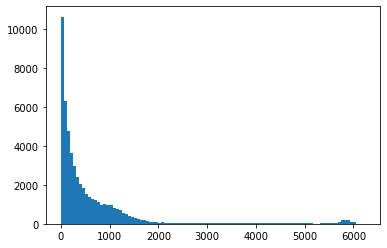

In [25]:
h = plt.hist([len(i) for i in unigrams], bins=100)

In [26]:
# flatten unigrams
flattened = [j for i in unigrams for j in i]

In [27]:
len(flattened)

33397214

In [28]:
bigrams = list(nltk.bigrams(flattened))
words_2 = nltk.FreqDist(bigrams)

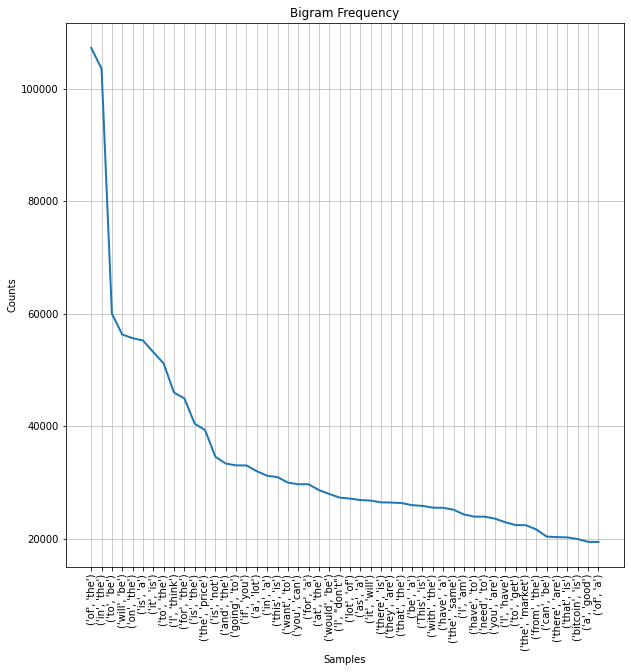

<AxesSubplot:title={'center':'Bigram Frequency'}, xlabel='Samples', ylabel='Counts'>

In [29]:
plt.figure(figsize=(10,10))
words_2.plot(50,title='Bigram Frequency')

In [30]:
list(words_2)[:20]
# may be more meaningful to do this after removing stopwords

[('of', 'the'),
 ('in', 'the'),
 ('to', 'be'),
 ('will', 'be'),
 ('on', 'the'),
 ('is', 'a'),
 ('it', 'is'),
 ('to', 'the'),
 ('I', 'think'),
 ('for', 'the'),
 ('is', 'the'),
 ('the', 'price'),
 ('is', 'not'),
 ('and', 'the'),
 ('going', 'to'),
 ('if', 'you'),
 ('a', 'lot'),
 ('in', 'a'),
 ('this', 'is'),
 ('want', 'to')]

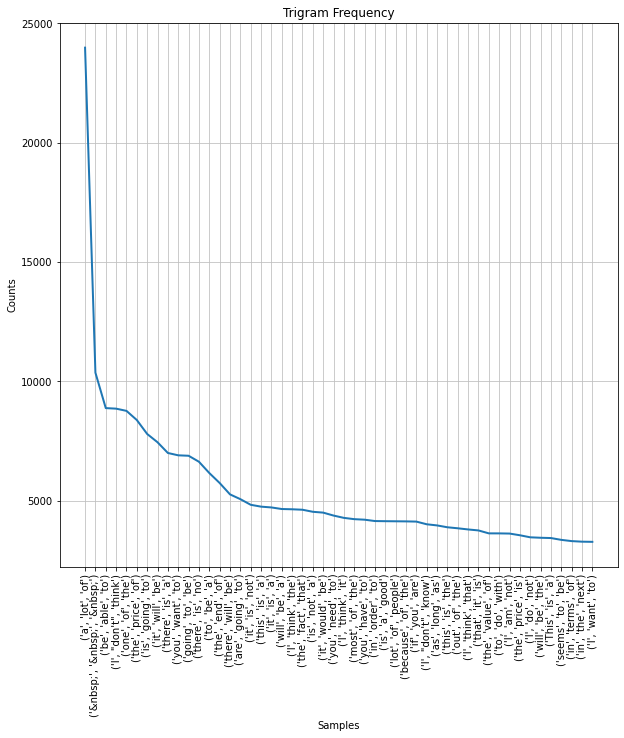

<AxesSubplot:title={'center':'Trigram Frequency'}, xlabel='Samples', ylabel='Counts'>

In [31]:
trigrams = list(nltk.trigrams(flattened))
words_3 = nltk.FreqDist(trigrams)
plt.figure(figsize=(10,10))
words_3.plot(50,title='Trigram Frequency')

In [38]:
mystopwords=stopwords.words("english") + ["n\'t", "\'s", "nbsp", "&nbsp;", "/div", "'ll", '\'m', "\'re", "/span", "also", "go", "say", "get", "see", "thread", "rule"]
flattened_nostop = [t for t in flattened if t not in mystopwords]


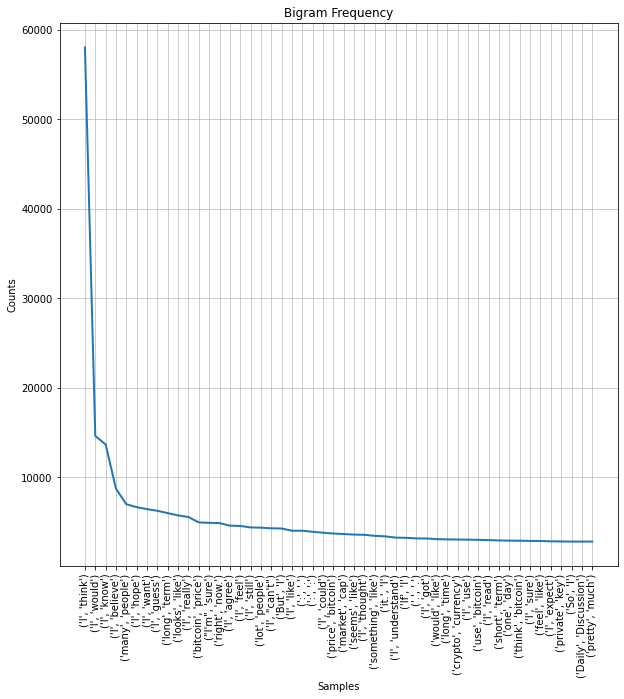

<AxesSubplot:title={'center':'Bigram Frequency'}, xlabel='Samples', ylabel='Counts'>

In [39]:
bigrams2 = list(nltk.bigrams(flattened_nostop))
words_3 = nltk.FreqDist(bigrams2)
plt.figure(figsize=(10,10))
words_3.plot(50,title='Bigram Frequency')

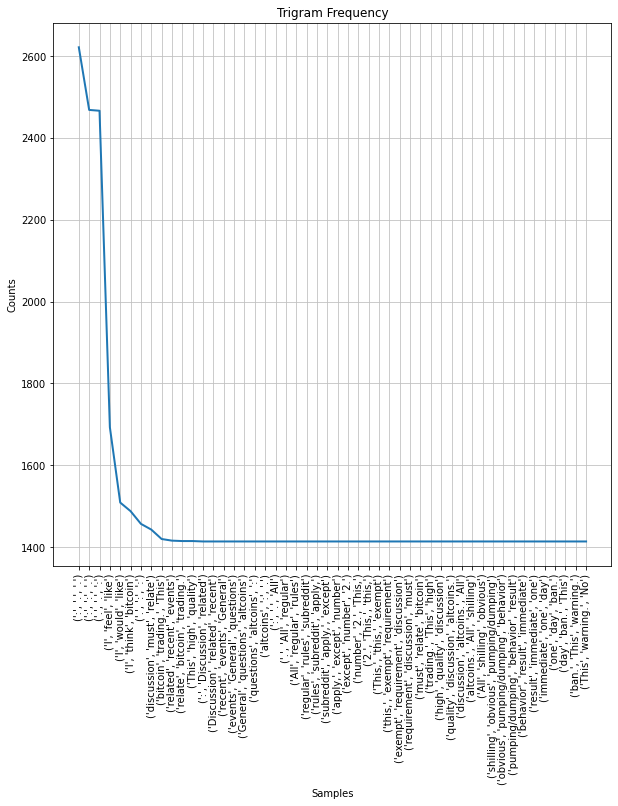

<AxesSubplot:title={'center':'Trigram Frequency'}, xlabel='Samples', ylabel='Counts'>

In [40]:
trigrams2 = list(nltk.trigrams(flattened_nostop))
words_3 = nltk.FreqDist(trigrams2)
plt.figure(figsize=(10,10))
words_3.plot(50,title='Trigram Frequency')
# all relating to the altcoin discussion posts

In [34]:
# Join mark and comment columns
posts['post'] = posts['mark'] + " " + posts['comment']

In [35]:
# Words specific to bitcoin that are likely not in the dictionary
# or used in crypto context in different ways than in normal language

model = {'bitcoin': 'NN',
'btc': 'NN',
'altcoin': 'NN',
'blockchain': 'NN',
'ethereum': 'NN',
'satoshi': 'NN',
'fiat': 'NN',
'crypto': 'NN',
'cryptocurrency': 'NN',
'okcoin': 'NP',
'bitfinex': 'NP',
'bfx': 'NP',
'huobi': 'NP',
'okex': 'NP',
'gdax': 'NP',
'coinbase': 'NP',
'kraken': 'NP',
'gemini': 'NP',
'binance': 'NP',
'okc': 'NP',
'bitcoin-e': 'NN',
'btce': 'NN',
'mtgox': 'NP',
'grayscale': 'NP',
'gbtc': 'NP',
'microstrategy': 'NP',
'etf':'NN',
'hashrate':'NN',
'nakamoto': 'NP',
'fomo': 'NN',
'ath': 'NN',
'long': 'NN',
'short': 'NN',
'ico': 'NN',
'fud': 'NN',
'moon': 'VB',
'pump': 'VB',
'dump': 'VB',
'bottom': 'VB',
'hedge': 'VB',
'usd': 'NN',
'eur': 'NN',
'bullish': 'JJ',
'bearish': 'JJ',
'bull': 'JJ'
}

In [53]:
# Add special bitcoin words to tagger (has priority over the pre-trained tagger)
# Where unknown word, assign as noun

default_tagger = nltk.tag.UnigramTagger(brown.tagged_sents(), backoff=nltk.DefaultTagger('NN'))
tagger = nltk.tag.UnigramTagger(model=model, backoff=default_tagger)
tagger.tag(word_tokenize("i would like to hodl some bitcoin. Feeling bullish about this"))


[('i', 'NN'),
 ('would', 'MD'),
 ('like', 'CS'),
 ('to', 'TO'),
 ('hodl', 'NN'),
 ('some', 'DTI'),
 ('bitcoin', 'NN'),
 ('.', '.'),
 ('Feeling', 'VBG'),
 ('bullish', 'JJ'),
 ('about', 'IN'),
 ('this', 'DT')]

In [54]:
tagger.tag(word_tokenize("A Plantoid similarly takes energy in the form of a bitcoin and uses the funds to reproduce. It exists as a sculpture (a plant version of an android) and as a blockchain smart contract.-What can you say about this ?"))


[('A', 'AT'),
 ('Plantoid', 'NN'),
 ('similarly', 'RB'),
 ('takes', 'VBZ'),
 ('energy', 'NN'),
 ('in', 'IN'),
 ('the', 'AT'),
 ('form', 'NN'),
 ('of', 'IN'),
 ('a', 'AT'),
 ('bitcoin', 'NN'),
 ('and', 'CC'),
 ('uses', 'VBZ'),
 ('the', 'AT'),
 ('funds', 'NNS'),
 ('to', 'TO'),
 ('reproduce', 'VB'),
 ('.', '.'),
 ('It', 'PPS'),
 ('exists', 'VBZ'),
 ('as', 'CS'),
 ('a', 'AT'),
 ('sculpture', 'NN'),
 ('(', '('),
 ('a', 'AT'),
 ('plant', 'NN'),
 ('version', 'NN'),
 ('of', 'IN'),
 ('an', 'AT'),
 ('android', 'NN'),
 (')', ')'),
 ('and', 'CC'),
 ('as', 'CS'),
 ('a', 'AT'),
 ('blockchain', 'NN'),
 ('smart', 'JJ'),
 ('contract.-What', 'NN'),
 ('can', 'MD'),
 ('you', 'PPSS'),
 ('say', 'VB'),
 ('about', 'IN'),
 ('this', 'DT'),
 ('?', '.')]

In [55]:
# POS tagging of all posts - store it in a list of lists
pos_posts = []

for post in posts['post']:
    tokens = word_tokenize(post)
    # tokens = [ t.lower() for t in tokens if t.lower() not in mystopwords]
    # tokens = [t for t in tokens if t not in punct]
    sent_pos = tagger.tag(tokens)
    pos_posts.append(sent_pos)
    

In [56]:
len(pos_posts)

53382

### Part II: Topic Modelling

1. Split by year
2. Topic modelling to find best number of topics per year (elbow graph)
3. Get topics for each year
4. Visualise the topics for each year
5. get typical document representing each topic for each year

In [41]:
posts['year'] = posts['date'].str[:4]

<AxesSubplot:xlabel='year', ylabel='Count'>

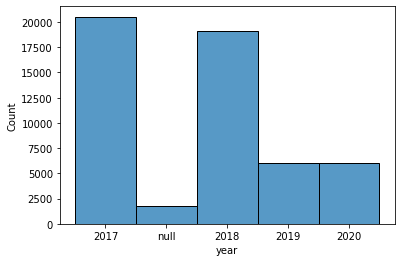

In [42]:
sns.histplot(posts['year'])

<AxesSubplot:xlabel='comment_len', ylabel='Count'>

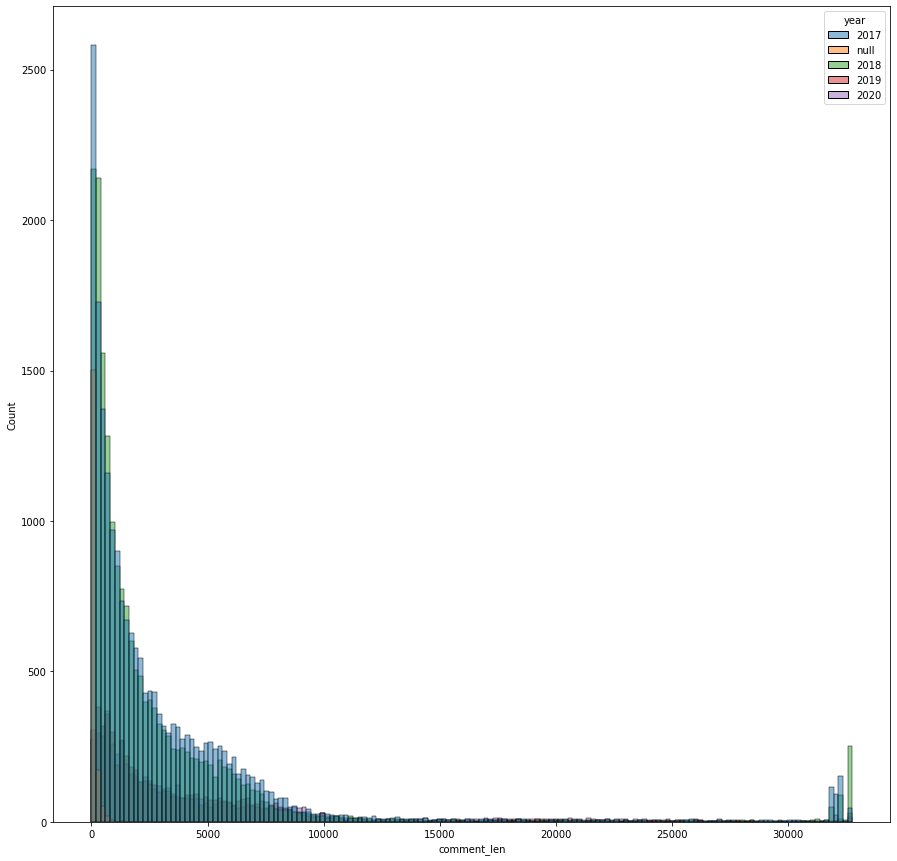

In [43]:
plt.figure(figsize=(15,15))
sns.histplot(posts, x='comment_len', hue='year')

In [48]:
## Functions and definitions

# Words specific to bitcoin that are likely not in the dictionary
# or used in crypto context in different ways than in normal language

model = {'bitcoin': 'NN',
'btc': 'NN',
'altcoin': 'NN',
'blockchain': 'NN',
'ethereum': 'NN',
'satoshi': 'NN',
'fiat': 'NN',
'crypto': 'NN',
'cryptocurrency': 'NN',
'okcoin': 'NP',
'bitfinex': 'NP',
'bfx': 'NP',
'huobi': 'NP',
'okex': 'NP',
'gdax': 'NP',
'coinbase': 'NP',
'kraken': 'NP',
'gemini': 'NP',
'binance': 'NP',
'okc': 'NP',
'bitcoin-e': 'NN',
'btce': 'NN',
'mtgox': 'NP',
'grayscale': 'NP',
'gbtc': 'NP',
'microstrategy': 'NP',
'etf':'NN',
'hashrate':'NN',
'nakamoto': 'NP',
'fomo': 'NN',
'ath': 'NN',
'long': 'NN',
'short': 'NN',
'ico': 'NN',
'fud': 'NN',
'moon': 'VB',
'pump': 'VB',
'dump': 'VB',
'bottom': 'VB',
'hedge': 'VB',
'usd': 'NN',
'eur': 'NN',
'bullish': 'JJ',
'bearish': 'JJ',
'bull': 'JJ'
}

# Part of speech tagger
default_tagger = nltk.tag.UnigramTagger(brown.tagged_sents(), backoff=nltk.DefaultTagger('NN'))
tagger = nltk.tag.UnigramTagger(model=model, backoff=default_tagger)

# Stopwords
wnl = nltk.WordNetLemmatizer()
mystopwords=stopwords.words("english") + ["bitcoin", "n\'t", "\'s", "nbsp", "&nbsp;", "/div", "'ll", '\'m', "\'re", "/span", "also", "go", "say", "get", "see", "thread", "rule"]
punct = '.,!?()""\'/<>\\^*#„\{\}....'

<>:60: DeprecationWarning: invalid escape sequence \{
<>:60: DeprecationWarning: invalid escape sequence \{
<>:60: DeprecationWarning: invalid escape sequence \{
<ipython-input-48-0fea1b469e6d>:60: DeprecationWarning: invalid escape sequence \{
  punct = '.,!?()""\'/<>\\^*#„\{\}....'


In [49]:
# Functions

def pre_process_docs(df):
    posts = df['mark'] + " " + df['comment']
    # POS tagging of all posts in df - store in a list of lists
    pos_posts = []
    for post in posts:
        tokens = word_tokenize(post)
        sent_pos = tagger.tag(tokens)
        pos_posts.append(sent_pos)
    
    # Extract all nouns, adjectives, verbs, adverbs (keep as separate posts)
    processed_docs = []
    for post in pos_posts:
        words = []
        for w, pos in post:
            if w.lower() not in mystopwords and w not in punct and pos[0] in ('N', 'V', 'J', 'R'): # noun, verb, adjective, adverb
                # lemmatize then add to list
                pos_label = 'a' if pos[0].lower() == 'j' else pos[0].lower()
                words.append(wnl.lemmatize(w.lower(), pos=pos_label))
        processed_docs.append(words)
    return processed_docs

# def create_topics(processed_docs, num_topics):
#     # Create dictionary from corpus
#     dictionary = corpora.Dictionary(processed_docs)
#     # Filter off  words with document frequency less than 3, or appearing in more than 90% of documents
#     dictionary.filter_extremes(no_below=3, no_above=0.90)
#     print(dictionary)
#     # Making Doc-term matrix using all words in the corpus
#     dtm = [dictionary.doc2bow(d) for d in processed_docs] 
#     # Topic modelling using LDA
#     lda = gensim.models.ldamodel.LdaModel(dtm, num_topics = num_topics,id2word = dictionary)
#     topics = lda.show_topics(num_words=15) 
#     # Compute Coherence Score using c_v
#     coherence_model_lda = CoherenceModel(model=lda, texts=processed_docs, dictionary=dictionary, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()
#     # Compute perplexity
#     perplexity_lda = lda.log_perplexity(dtm)  
#     print('\nCoherence Score: ', coherence_lda)
#     print('Perplexity Score:', perplexity_lda)  
#     return topics, coherence_lda, perplexity_lda

In [50]:
processed_docs = pre_process_docs(posts)
print("processed")

processed


In [51]:
print(len(processed_docs))
print(processed_docs[0])

53382
['bitcoin-eating', 'robot', 'plantoid', 'similarly', 'take', 'energy', 'form', 'use', 'fund', 'reproduce', 'exist', 'sculpture', 'plant', 'version', 'android', 'blockchain', 'smart', 'contract.-what', 'read', 'hybrid', 'entity', 'exist', 'virtual', 'physical', 'realm', 'interact', 'entity', 'blockchain.in', 'physical', 'form', 'plantoid', 'mechanical', 'structure', 'public', 'space', 'exhibit', 'beauty', 'seek', 'donation', 'wallet', 'base', 'attractiveness.', 'amazing', 'thing', 'robotic', 'plant', 'live', 'receive', 'donation', 'look', 'wallet', 'root', 'look', 'food', 'actually', 'look', 'receive', 'however', 'art', 'cool', 'picture', 'flower', 'light', 'beautiful', 'hybrid', 'eat', 'b', 'story', 'epic', 'proportion', 'dude', 'hit', 'line', 'talcum', 'powder', 'good', 'news', 'innovation', 'believe', 'technology', 'growth', 'fast', 'technology', 'almost', 'human', 'work', 'maybe', 'future', 'use', 'robot', 'mine', 'activity', 'send', 'receive', 'way', 'use', 'wallet', 'future'

In [52]:
# Save processed_docs as pickle file
import pickle 
with open('processed_docs.pkl', 'wb') as filehandler:
    pickle.dump(processed_docs, filehandler)

In [53]:
#######################################################################
# Open processed_docs from pickle file
with open('processed_docs.pkl', 'rb') as filehandler:
    processed_docs = pickle.load(filehandler)

In [ ]:
# mytopics, coh_score, per_score = create_topics(processed_docs, 5)
# print(mytopics)
# If this works, move down

In [54]:
# function to get coherence scores for range of numbers of topics, and plot coherence score graph 

def topics_and_coherence(processed_docs, start_num, num_range):
    # Create dictionary from corpus
    dictionary = corpora.Dictionary(processed_docs)
    # Filter off  words with document frequency less than 3, or appearing in more than 90% of documents
    dictionary.filter_extremes(no_below=3, no_above=0.90)
    # Making Doc-term matrix using all words in the corpus
    dtm = [dictionary.doc2bow(d) for d in processed_docs] 
    
    # df to store topics and coherence scores
    tc_df = pd.DataFrame(columns=['num_topics', 'coherence_score', 'perplexity_lda', 'topics', 'lda_model'])

    for i in range(start_num, num_range):
        print("\nnumber of topics:", i)
        # Topic modelling using LDA
        lda_model = gensim.models.ldamodel.LdaModel(dtm, num_topics = i, id2word = dictionary)
        topics = lda_model.show_topics(num_words=15) 
        # Compute Coherence Score using c_v
        coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        print('Coherence Score: ', coherence_lda)
        # Compute perplexity
        perplexity_lda = lda_model.log_perplexity(dtm)
        print('Perplexity Score:', perplexity_lda)
        # Store topics and coherence score in tc_df
        tc_df.loc[len(tc_df)] = [i, coherence_lda, perplexity_lda, topics, lda_model]
    return tc_df


In [55]:
result_df2 = topics_and_coherence(processed_docs, 2, 7)


number of topics: 2
Coherence Score:  0.32498318334427023
Perplexity Score: -7.639870922820193

number of topics: 3
Coherence Score:  0.33747534687029845
Perplexity Score: -7.615755044890057

number of topics: 4
Coherence Score:  0.36213201475638324
Perplexity Score: -7.602531716985386

number of topics: 5
Coherence Score:  0.36611322624530207
Perplexity Score: -7.599790603525524

number of topics: 6
Coherence Score:  0.3812455948368116
Perplexity Score: -7.609555067961737


In [56]:
result_df2

num_topics  coherence_score  perplexity_lda  \
0          2         0.324983       -7.639871   
1          3         0.337475       -7.615755   
2          4         0.362132       -7.602532   
3          5         0.366113       -7.599791   
4          6         0.381246       -7.609555   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        topics  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           [(0, 0.013*"$" + 0.013*"price" + 0.010*"market" + 0.009*"btc" + 0.009*"time" + 0.009*"buy" + 0.008*"think" + 0.008*"go" + 0.007*"trade" + 0.007*"%" + 0.006*"long" + 0.006*"look" + 0.006*"day" + 0.006*"year" + 0.006*"sell"), (1, 0.013*"use" + 0.013*"people" + 0.009*"think" + 0.008*"make" + 0.008*"crypto" + 0.007*"know" + 0.007*"good" + 0.006*"money" + 0.006*"transaction" + 0.006*"even" + 0.006*"time" + 0.005*"need" + 0.005*"wallet" + 0.005*"btc" + 0.005*"thing")]   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            [(0, 0.014*"$" + 0.013*"price" + 0.010*"market" + 0.009*"b

In [58]:
# Save the dataframe
with open('topics_coh_results_all.pkl', 'wb') as filehandler:
    pickle.dump(result_df2, filehandler)

<AxesSubplot:xlabel='num_topics', ylabel='coherence_score'>

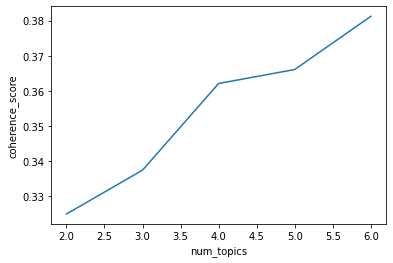

In [60]:
sns.lineplot(data=result_df2, x="num_topics", y="coherence_score")

In [62]:
# pyLDAvis for all data
chosen_model = result_df2.iloc[4,4]
dictionary = corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=3, no_above=0.90)
dtm = [dictionary.doc2bow(d) for d in processed_docs] 

In [63]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(chosen_model, dtm, dictionary)
LDAvis_prepared

1  -5.6128   
587                edit    7610.465341    9194.799818   Topic1  -6.3620   
482               close   15452.684270   21703.550431   Topic1  -5.6538   
802                long   33565.473574   56907.201776   Topic1  -4.8781   
75                 look   33465.491009   59423.658147   Topic1  -4.8811   
808                 low   23373.718272   38434.380518   Topic1  -5.2400   
577                dump   13537.349754   19635.901686   Topic1  -5.7861   
174                  go   38887.406486   82426.587079   Topic1  -4.7309   
962                pump   12214.562349   17704.037976   Topic1  -5.8889   
256                   %   30217.449889   62798.385579   Topic1  -4.9832   
821              market   40153.901591   99430.208744   Topic1  -4.6989   
145                back   23405.743905   45860.600904   Topic1  -5.2386   
848               month   17004.996242   28779.197882   Topic1  -5.5581   
532                 day   27053.273792   57284.204749   Topic1  -5.0938   
1480                 ¢s   17808.492398   31000.204487   Topic1  -5.5119   
231                time   39886.538069  110030.321426   Topic1  -4.7055   
952               price   43497.081183  128143.942518   Topic1  -4.6189   
445                 buy   34155.658190   90119.613734   Topic1  -4.8606   
852                move   19159.951122   35241.969096   Topic1  -5.4388   
230               think   37645.228356  125358.426800   Topic1  -4.7634   
716                high   23443.424744   57801.558936   Topic1  -5.2370   
20                  btc   32965.551490  114697.683583   Topic1  -4.8961   
685                 get   22547.039673   53794.627548   Topic1  -5.2760   
254                year   24607.618937   67223.354041   Topic1  -5.1885   
52                 good   24309.923879   92833.604228   Topic1  -5.2007   
1037               sell   19439.171275   55148.914032   Topic1  -5.4243   
224               still   20533.063495   71994.998910   Topic1  -5.3695   
1168              trade   20220.115397   71471.682544   Topic1  -5.3849   
76                 make   21698.791616  107042.023440   Topic1  -5.3143   
84               people   20463.112661  136696.860743   Topic1  -5.3730   
119                take   17532.982832   58680.295500   Topic1  -5.5275   
4783           legalize    1093.577994    1094.812840   Topic2  -8.1740   
1489           cashless     592.071743     592.912385   Topic2  -8.7876   
5295        documentary     697.083798     698.251342   Topic2  -8.6243   
12840      unemployment     616.652565     617.823162   Topic2  -8.7469   
8447               musk    1063.662361    1065.704862   Topic2  -8.2018   
48571              cbdc     511.948415     512.961988   Topic2  -8.9330   
20919        bangladesh     411.923071     412.752949   Topic2  -9.1504   
8595                rbi     396.436951     397.262469   Topic2  -9.1887   
9013           stimulus    1778.684055    1783.151744   Topic2  -7.6876   
13469           african     577.559130     579.074464   Topic2  -8.8124   
10222      crowdfunding     310.184324     311.161022   Topic2  -9.4341   
10070          jpmorgan     374.137750     375.323422   Topic2  -9.2466   
4673             indian    1418.975422    1423.570984   Topic2  -7.9135   
28837            keiser     255.647955     256.500160   Topic2  -9.6274   
9523            poverty     435.172491     436.632608   Topic2  -9.0955   
22257     environmental     276.543576     277.480738   Topic2  -9.5489   
1478             weapon     383.403030     384.726756   Topic2  -9.2221   
29363        e-commerce     240.891739     241.727600   Topic2  -9.6869   
12972              iraq     239.202357     240.110747   Topic2  -9.6939   
32670             petro     212.746374     213.574316   Topic2  -9.8111   
49282              fatf     214.103816     214.959241   Topic2  -9.8048   
39126               g20     227.756369     228.681817   Topic2  -9.7430   
22696              yang     206.061305     206.904459   Topic2  -9.8431   
23635      

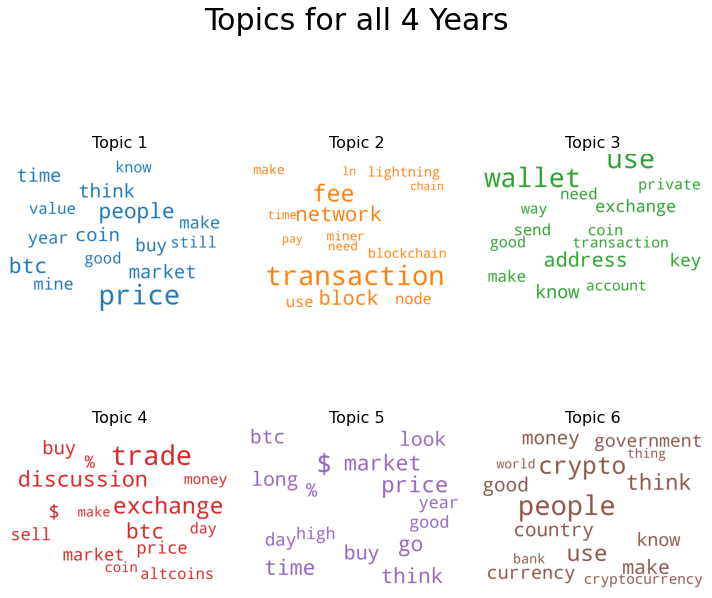

In [65]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

cloud = WordCloud(stopwords=None,
                background_color='white',
                width=2500,
                height=1800,
                max_words=15,
                colormap='tab10',
                color_func=lambda *args, **kwargs: cols[i],
                prefer_horizontal=1.0)

topics = result_df2.iloc[4,4].show_topics(num_words=15,formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)
fig.suptitle(f'Topics for all 4 Years', fontsize=30)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(f'Topic {i+1}', fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [66]:
topicdict = {0: 'topic 1', 1: 'topic 2', 2: 'topic 3', 3:'topic 4', 4:'topic 5', 5:'topic 6'}

# Get the topic distribution of documents
doc_topics = chosen_model.get_document_topics(dtm)
#show the topic distributions for the first 5 docs, 
for i in range(6):
    print(doc_topics[i])

# Select the best topic (with highest score) for each document
from operator import itemgetter
top_topic = [ max(t, key=itemgetter(1))[0] for t in doc_topics ]
topics_perDoc = [ topicdict[t] for t in top_topic ]

[(0, 0.058236375), (2, 0.17743534), (4, 0.046861812), (5, 0.7155839)]
[(2, 0.9568256), (5, 0.040333744)]
[(0, 0.021222973), (1, 0.020983078), (2, 0.021048687), (3, 0.020963153), (4, 0.5122973), (5, 0.40348485)]
[(0, 0.06462069), (1, 0.021719053), (3, 0.19072223), (4, 0.6127974), (5, 0.10182742)]
[(1, 0.24037041), (2, 0.7174257), (5, 0.03586028)]
[(2, 0.14533111), (3, 0.8254108)]


In [68]:
# Number of documents in each topic
labels, counts = np.unique(topics_perDoc, return_counts=True)
print (labels)
print (counts)

['topic 1' 'topic 2' 'topic 3' 'topic 4' 'topic 5' 'topic 6']
[ 9415  5261  8450  4881  6174 19201]


In [ ]:
###################################################################
# Split by year

In [69]:
posts_2017 = posts.loc[posts['date'].str.startswith('2017')]
posts_2018 = posts.loc[posts['date'].str.startswith('2018')]
posts_2019 = posts.loc[posts['date'].str.startswith('2019')]
posts_2020 = posts.loc[posts['date'].str.startswith('2020')]

posts_2017.name = 'posts_2017'
posts_2018.name = 'posts_2018'
posts_2019.name = 'posts_2019'
posts_2020.name = 'posts_2020'

In [ ]:
for df in [posts_2017, posts_2018, posts_2019, posts_2020]:
    print(f'{df.name}')
    processed_docs = pre_process_docs(posts)
    with open(f'processed_{df.name}.pkl', 'wb') as filehandler:
        pickle.dump(processed_docs, filehandler)
    print("pre-processed")
    result_df = topics_and_coherence(processed_docs, 2, 25)
    print("got topics")
    with open(f'topics_{df.name}.pkl', 'wb') as filehandler:
        pickle.dump(result_df, filehandler)


In [70]:
# plot coherence scores for all years
with open('topics_posts_2017.pkl', 'rb') as filehandler:
    topic_posts_2017 = pickle.load(filehandler)
with open('topics_posts_2018.pkl', 'rb') as filehandler2:
    topic_posts_2018 = pickle.load(filehandler2)
with open('topics_posts_2019.pkl', 'rb') as filehandler3:
    topic_posts_2019 = pickle.load(filehandler3)
with open('topics_posts_2020.pkl', 'rb') as filehandler4:
    topic_posts_2020 = pickle.load(filehandler4)

In [71]:
topic_posts_2017.head()

num_topics  coherence_score  perplexity_lda  \
0          2         0.307164       -7.599496   
1          3         0.349484       -7.567387   
2          4         0.346934       -7.551292   
3          5         0.370742       -7.573824   
4          6         0.366637       -7.579106   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            topics  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 [(0, 0.013*"use" + 0.013*"people" + 0.009*"think" + 0.008*"make" + 0.007*"crypto" + 0.007*"know" + 0.007*"good" + 0.006*"get" + 0.006*"money" + 0.006*"also" + 0.006*"transaction" + 0.005*"time" + 0.005*"even" + 0.005*"need" + 0.005*"wallet"), (1, 0.013*"$" + 0.012*"price" + 0.011*"go" + 0.009*"market" + 0.009*"get" + 0.009*"btc" + 0.009*"buy" + 0.008*"time" + 0.008*"think" + 0.007*"trade" + 0.007*"see" + 0.006*"%" + 0.006*"long" + 0.006*"year" + 0.006*"look")]   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                [(0, 0.014*"$" + 0.013*"price" + 0.012*"go" + 0.010*"market" + 0.009*"btc" + 0

In [72]:
# Add column 'year' then combine all years into single dataframe, for plotting
topic_posts_2017['year'] = '2017'
topic_posts_2018['year'] = '2018'
topic_posts_2019['year'] = '2019'
topic_posts_2020['year'] = '2020'

In [73]:
topic_posts_df = pd.concat([topic_posts_2017, topic_posts_2018, topic_posts_2019, topic_posts_2020])
topic_posts_df.shape

(92, 6)

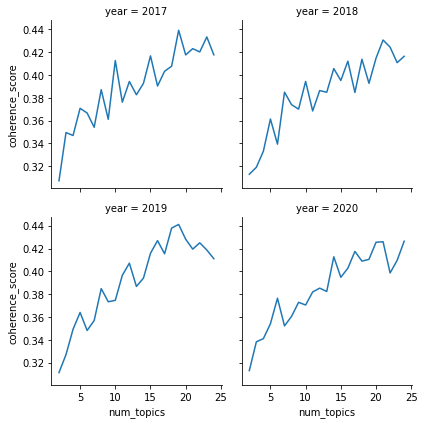

In [74]:
# Plot facetgrid
g = sns.FacetGrid(topic_posts_df, col='year', col_wrap=2)
g.map(sns.lineplot,'num_topics', 'coherence_score')

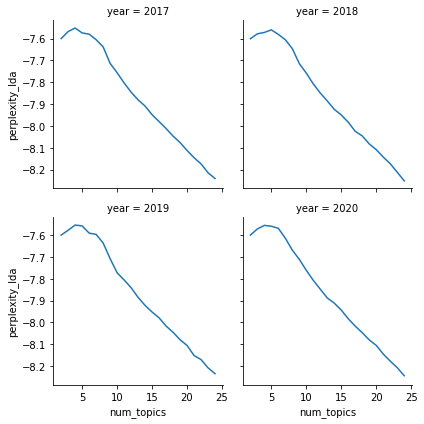

In [75]:
h = sns.FacetGrid(topic_posts_df, col='year', col_wrap=2)
h.map(sns.lineplot,'num_topics', 'perplexity_lda')

In [76]:
# Choose num_topics = 6 for each year:
print("2017 topics=6")
pprint(topic_posts_df.loc[(topic_posts_df['num_topics']==6) & (topic_posts_df['year']=='2017'), 'topics'].tolist())

# Needs to be visualised in a wordcloud

2017 topics=6
[[(0,
   '0.022*"price" + 0.020*"buy" + 0.019*"btc" + 0.013*"sell" + 0.012*"market" '
   '+ 0.012*"$" + 0.011*"time" + 0.011*"go" + 0.011*"trade" + 0.011*"coin" + '
   '0.010*"get" + 0.010*"make" + 0.010*"money" + 0.009*"good" + '
   '0.009*"invest"'),
  (1,
   '0.019*"discussion" + 0.011*"market" + 0.009*"¢s" + 0.007*"altcoins" + '
   '0.006*"“" + 0.006*"thread" + 0.006*"price" + 0.006*"relate" + 0.006*"say" '
   '+ 0.005*"ã¢â‚¬å" + 0.005*"daily" + 0.005*"\'re" + 0.005*"post" + '
   '0.005*"news" + 0.005*"year"'),
  (2,
   '0.018*"transaction" + 0.012*"use" + 0.012*"wallet" + 0.011*"satoshi" + '
   '0.011*"fee" + 0.010*"mine" + 0.009*"network" + 0.008*"make" + '
   '0.008*"address" + 0.008*"block" + 0.008*"btc" + 0.008*"miner" + '
   '0.007*"coin" + 0.007*"think" + 0.007*"people"'),
  (3,
   '0.016*"$" + 0.013*"go" + 0.011*"price" + 0.009*"get" + 0.009*"think" + '
   '0.009*"time" + 0.009*"market" + 0.008*"see" + 0.007*"long" + 0.007*"btc" + '
   '0.007*"look" + 0.007*"b

In [77]:
# Format for wordcloud
# topic_posts_df.loc[(topic_posts_df['num_topics']==6) & (topic_posts_df['year']=='2017'), 'lda_model']
topic_posts_df.iloc[4,4].show_topics(formatted=False)[0][1]

[('price', 0.021640712),
 ('buy', 0.020146772),
 ('btc', 0.019356636),
 ('sell', 0.012857346),
 ('market', 0.012267906),
 ('$', 0.01158568),
 ('time', 0.011404661),
 ('go', 0.011270883),
 ('trade', 0.011043029),
 ('coin', 0.010525827)]

In [78]:
# 1. Wordcloud of Top N words in each topic
# code adapted from https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
def topic_wordclouds(df, rownum, text):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

    cloud = WordCloud(stopwords=None,
                    background_color='white',
                    width=2500,
                    height=1800,
                    max_words=15,
                    colormap='tab10',
                    color_func=lambda *args, **kwargs: cols[i],
                    prefer_horizontal=1.0)

    topics = df.iloc[rownum,4].show_topics(num_words=15,formatted=False)

    fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)
    fig.suptitle(f'{text}', fontsize=30)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title(f'Topic {i}', fontdict=dict(size=16))
        plt.gca().axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

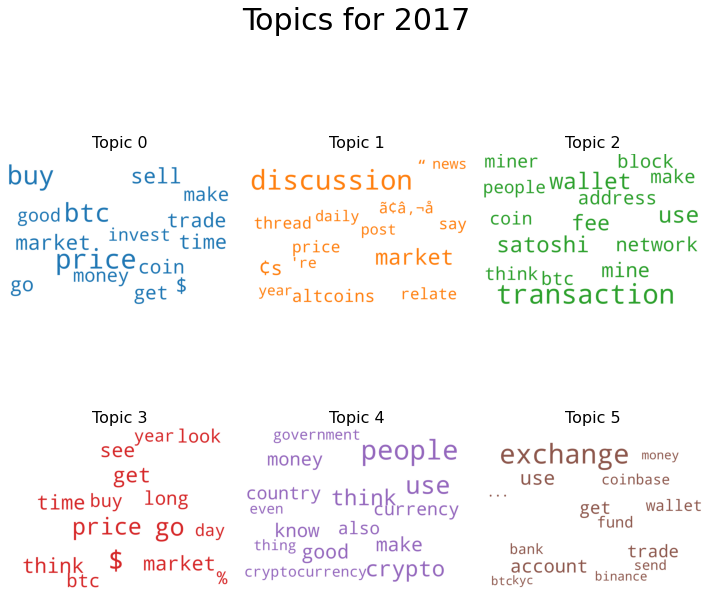

In [79]:
topic_wordclouds(topic_posts_df, 4, 'Topics for 2017')

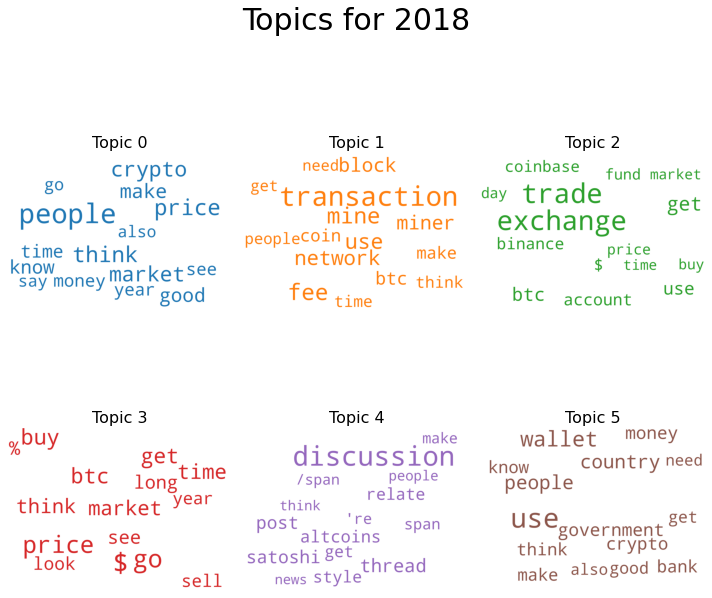

In [80]:
topic_wordclouds(topic_posts_df, 27, 'Topics for 2018')

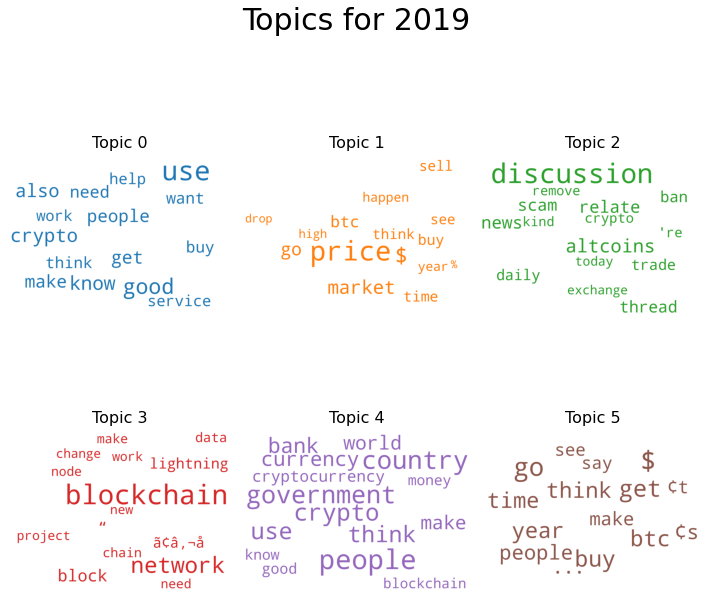

In [81]:
topic_wordclouds(topic_posts_df, 40, 'Topics for 2019')

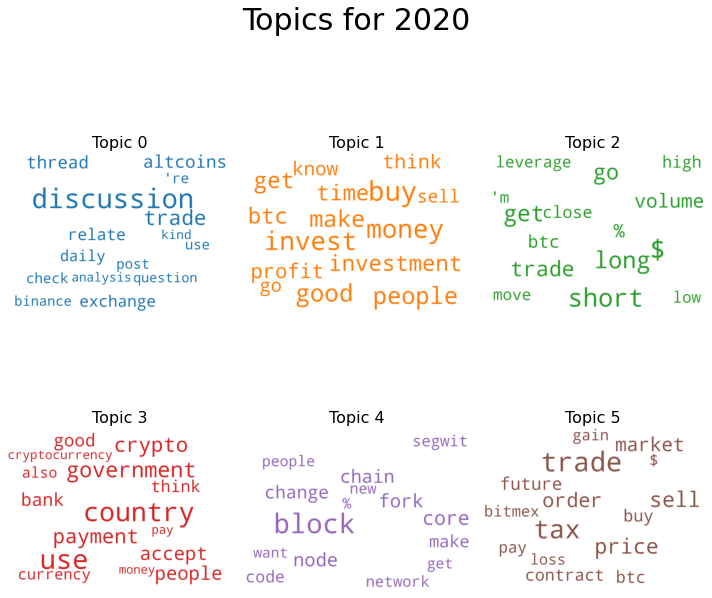

In [82]:
topic_wordclouds(topic_posts_df, 63, 'Topics for 2020')

In [83]:
with open('processed_posts_2017.pkl', 'rb') as filehandler:
    processed_posts_2017 = pickle.load(filehandler)
with open('processed_posts_2018.pkl', 'rb') as filehandler:
    processed_posts_2018 = pickle.load(filehandler)
with open('processed_posts_2019.pkl', 'rb') as filehandler:
    processed_posts_2019 = pickle.load(filehandler)
with open('processed_posts_2020.pkl', 'rb') as filehandler:
    processed_posts_2020 = pickle.load(filehandler)

In [84]:
# Function to display pyLDAvis for each year

def show_pyldavis(processed_posts, model_df):
    model = model_df.iloc[4,4]
    dictionary = corpora.Dictionary(processed_posts)
    dictionary.filter_extremes(no_below=3, no_above=0.90)
    dtm = [dictionary.doc2bow(d) for d in processed_posts]
    pyLDAvis.enable_notebook()
    return pyLDAvis.gensim.prepare(model, dtm, dictionary)

In [85]:
show_pyldavis(processed_posts_2017, topic_posts_2017)

57084.067455   Topic1  -4.8955   
1223                weekly   18612.740461   23410.543418   Topic1  -5.6677   
181      government-issued   71183.699198  121936.083538   Topic1  -4.3263   
264             'arbitrage   34834.123157   51379.525457   Topic1  -5.0410   
493                   club   18628.389323   24262.307197   Topic1  -5.6669   
858                   moon   20376.882214   27916.956923   Topic1  -5.5771   
831                massive   45902.537172   79466.563028   Topic1  -4.7650   
77                    look   38446.463334   63148.708608   Topic1  -4.9423   
456                   cafe   37146.187002   61838.030021   Topic1  -4.9767   
543                 debate   31482.264611   54226.073878   Topic1  -5.1421   
267                    've   30574.964193   53028.820277   Topic1  -5.1714   
152               bitcoins   28393.802030   47699.278343   Topic1  -5.2454   
726             historical   28980.142148   49197.780209   Topic1  -5.2249   
111                    see   44436.552698   92452.669207   Topic1  -4.7975   
237                  title   46827.183135  100097.128156   Topic1  -4.7451   
52                     get   51006.847535  121190.592658   Topic1  -4.6596   
21                     btc   39626.918466   86314.961173   Topic1  -4.9120   
260                      {   32322.144130   62874.453930   Topic1  -5.1158   
235                 thread   48373.439661  126987.108306   Topic1  -4.7126   
862                    mum   23188.826811   36860.627836   Topic1  -5.4479   
270                 ......   28105.074949   53330.484775   Topic1  -5.2556   
1047                 sense   22305.939570   34575.922555   Topic1  -5.4867   
1177                 train   25234.861259   56752.319370   Topic1  -5.3633   
54                    good   27441.665535   87384.585325   Topic1  -5.2795   
229                  style   25665.302145   70477.417938   Topic1  -5.3464   
86                  people   27749.528896  136635.269058   Topic1  -5.2683   
78                    make   24478.792625   98585.809518   Topic1  -5.3937   
1498                common     792.909989     793.673643   Topic2  -8.7444   
20928              bolivia     468.081233     468.781431   Topic2  -9.2715   
8323                  pine     946.947439     948.676781   Topic2  -8.5668   
8604             saddening     448.160144     449.048205   Topic2  -9.3149   
4667           bitcoin.the     381.394561     382.201336   Topic2  -9.4763   
5126          unbelievably     364.779111     365.572926   Topic2  -9.5208   
10319                  mew     305.334181     306.109205   Topic2  -9.6987   
29372               encode     270.050358     270.752256   Topic2  -9.8215   
8133                twinge     280.274917     281.015136   Topic2  -9.7843   
3609                    5+     274.969681     275.733522   Topic2  -9.8034   
17064              family.     267.391585     268.167215   Topic2  -9.8314   
32679             shoddily     235.491710     236.198383   Topic2  -9.9584   
10231            advance.i     422.226546     423.567816   Topic2  -9.3746   
9532                too.we     618.676013     620.660015   Topic2  -8.9925   
22705                  ssl     215.857462     216.560500   Topic2 -10.0455   
6782             miserable     256.198852     257.053869   Topic2  -9.8741   
23644           undeclared     237.299029     238.121778   Topic2  -9.9508   
32633           cryptos.do     205.438254     206.178698   Topic2 -10.0949   
48577               yearso     573.610310     575.678631   Topic2  -9.0681   
22053             wireless     199.704114     200.430062   Topic2 -10.1233   
28878        currencies.on     206.978462     207.743214   Topic2 -10.0875   
14978              trezor.     194.542227     195.278612   Topic2 -10.1494   
15013                 priv     227.497762     228.362176   Topic2  -9.9930   
145                address     193.646713     194.430619   Topic2 -10.1541   
6318                 brink     192.242775     193.042181   Topic2 

In [86]:
show_pyldavis(processed_posts_2018, topic_posts_2018)

favourite     193.668705     199.972390   
8437                   governments/banks    1058.076079    1150.023926   
7784                          mayweather     111.414864     114.694035   
3356                          mined.with     361.970158     386.622530   
5787                          washington     627.107614     693.155532   
8531                              lovely     150.980233     157.764310   
4865                          correcting     514.531491     568.015409   
8293                            laziness     331.329127     361.004843   
28108                correction/reversal     135.207430     141.013700   
32633                         cryptos.do     123.703330     128.687577   
8372                               fake.     361.929602     402.355350   
1236                                wont     731.823715     852.071457   
773                                ivans   10205.642042   14447.609170   
1983                              invite   13632.499780   19730.650439   
1984                                isnt   11769.304833   17091.396121   
7777                         destabilize     319.692893     354.062914   
702                           government   10283.920342   14821.383363   
4644                                 cah     780.228577     939.858295   
934                                 plan     903.102727    1108.013012   
5598                              burden     425.594110     491.559525   
8306                              needed     444.796940     518.141346   
9995                  currency/commodity     300.285217     338.064411   
531                               crypto    2176.286689    3002.407984   
2819                             venture     691.135966     868.921891   
1211                                vega   13792.947446   25582.075646   
2383                              afford    6051.115290   10477.652785   
55                                  grow    4558.410258    7811.805133   
139                                world   13316.339835   26919.086173   
1215                              volume    2192.985805    3487.857034   
124                           technology    7279.629032   14342.939786   
86                                people   44818.103940  124015.170061   
655                                finex    5629.452912   10712.341027   
536                            currently   13773.873678   31664.321076   
1355                   currenciesã¢â‚¬â   12813.169746   29210.702253   
2403                           off-chain    2300.529453    3713.176032   
2368                              scheme    3001.942462    5132.596980   
1104                               stake    2845.769171    4814.333036   
51                                future   11202.841982   25594.427325   
533                                  cup   26179.587790   72701.490237   
378                               assume    8083.574563   17381.187187   
822                               making    1726.206328    2651.806764   
699                                 goal    3392.232168    6199.177247   
838                                 ment    4017.045951    7710.592138   
831                              massive   25668.659922   85149.963608   
159                               comply    7796.352909   18764.911689   
17                               believe    9006.818130   23085.218773   
962                             probable   28480.909954  105598.992734   
401                                 beer    8305.569520   20851.159990   
260                                    {   17360.589913   60594.624010   
84                                  news   10245.239306   29243.542694   
235                               thread   27808.016265  118527.783001   
71                                  know   20464.745377   82494.626289   
54                                  good   21387.903700   89371.903214   
1354                       cryptographic    5558.418029   12700.285388   
201                                

In [87]:
show_pyldavis(processed_posts_2019, topic_posts_2019)

lunar   18855.119503   36805.500475   
77                                  look   25482.202436   63840.879823   
456                                 cafe   23747.006905   57625.781218   
862                                  mum   18075.882520   37471.683591   
237                                title   31626.229685   93754.496008   
726                           historical   20711.368071   48293.768233   
264                           'arbitrage   21888.671216   55179.327347   
152                             bitcoins   19205.186096   43985.993833   
52                                   get   31226.519571  119772.708097   
108                                  say   22346.168634   63194.765898   
413                           bitcoiners   18011.992127   43099.787802   
184                             identity   18161.703514   44723.535253   
21                                   btc   22753.976103   84268.941800   
86                                people   25903.467512  123421.073795   
54                                  good   22023.124881   86451.949831   
78                                  make   21720.310799   99015.984110   
543                               debate   18472.798550   55270.230632   
229                                style   18701.020730   64855.983327   
41427                           bitgrail     870.817956     871.506631   
20297                        account.but     890.823494     891.738980   
10221                             revile    1780.912484    1783.662842   
36242                                idr     819.928243     822.007042   
41014                              stong     255.905665     256.601456   
41013                           yes.this     255.624208     256.319769   
32966                               gchq     558.259278     559.874529   
16861                              biggy     279.520678     280.334445   
30195                       every-single     288.104412     289.104630   
21000                       alphabetical     191.949621     192.631371   
9377                                shed     225.990072     226.867819   
18094                         process.to     176.870414     177.573968   
31928                               smdh     214.736540     215.621852   
27305                               wuss     162.768410     163.450766   
33995                         divestment     160.037461     160.767527   
19632                            godaddy     130.809168     131.549553   
50458                        familiarise     117.440843     118.129917   
22998                              also.     125.072786     125.823910   
23358                      discontinuing     116.440742     117.141171   
4466                           withdraws     127.762738     128.594977   
26266                              4000.     105.726006     106.430428   
28646                           draining     107.282651     107.998018   
22165                                org     112.404161     113.157527   
22353              dollar-cost-averaging     209.662583     211.108646   
50785                              7,070     242.183663     243.855043   
23352                           bfx_drew      97.481376      98.177103   
24604                         matter.the      91.005012      91.700951   
23301                             facts.     125.502066     126.481307   
23558                             colony     110.119240     110.989655   
10645                               btc/     136.988239     138.086197   
785                                  lad    4416.478415    4457.644332   
23207                              heheh    3883.121814    3945.430265   
30351                         multiplied    1701.674564    1722.976503   
51101                                mau    3851.964133    3940.186760   
2371                           tolerates    4842.543831    4977.450420   
10627                              9000s     758.743541     769.520709   
14750                        bitcoin.yo

In [88]:
show_pyldavis(processed_posts_2020, topic_posts_2020)

bitcoins   23222.995723   43429.582540   Topic1  -5.3710   
237                  title   35210.794744   96150.121436   Topic1  -4.9548   
1489                ã¢â‚¬å   19948.047856   33769.656187   Topic1  -5.5230   
831                massive   28007.716132   69009.237738   Topic1  -5.1836   
141                     ..   22578.678866   44290.054181   Topic1  -5.3991   
235                 thread   33613.706323  121217.409493   Topic1  -5.0012   
726             historical   22672.481454   47333.440870   Topic1  -5.3950   
21                     btc   22683.622124   82574.791683   Topic1  -5.3945   
54                    good   22750.654540   91633.327322   Topic1  -5.3915   
456                   cafe   19443.474317   58439.710586   Topic1  -5.5486   
78                    make   19866.009259  102022.871214   Topic1  -5.5271   
1498                common     823.327895     824.067009   Topic2  -8.6722   
20928              bolivia     485.953519     486.668060   Topic2  -9.1994   
48577               yearso     602.297949     603.364581   Topic2  -8.9848   
9532                too.we     642.657676     644.059031   Topic2  -8.9199   
12981                known     391.974763     392.845868   Topic2  -9.4143   
2861               unleash     610.554009     612.042134   Topic2  -8.9712   
29372               encode     280.604530     281.318475   Topic2  -9.7486   
28846            northward     312.611337     313.436690   Topic2  -9.6406   
39134            judiciary     265.703797     266.442695   Topic2  -9.8031   
17064              family.     275.848393     276.661728   Topic2  -9.7657   
4667           bitcoin.the     395.045928     396.231699   Topic2  -9.4065   
32679             shoddily     244.678746     245.416020   Topic2  -9.8856   
24129              non-kyc     253.349907     254.124287   Topic2  -9.8508   
4792                locate    1267.937707    1272.024938   Topic2  -8.2404   
25272             landlord     255.444996     256.279863   Topic2  -9.8425   
32633           cryptos.do     214.091269     214.819339   Topic2 -10.0191   
22053             wireless     207.478475     208.213168   Topic2 -10.0505   
7777           destabilize     570.606830     572.700845   Topic2  -9.0388   
19293              safello     188.715074     189.434953   Topic2 -10.1453   
7784            mayweather     190.244449     190.982909   Topic2 -10.1372   
19810              merrier     177.934450     178.654379   Topic2 -10.2041   
9728             converted     225.376193     226.295202   Topic2  -9.9678   
25449               0.25mb     175.513915     176.235265   Topic2 -10.2178   
4800                 shore     367.490987     369.011748   Topic2  -9.4788   
11202               deputy     185.042382     185.816490   Topic2 -10.1649   
15842            inovation     168.618220     169.332529   Topic2 -10.2579   
20692           adolescent     172.841606     173.582730   Topic2 -10.2332   
6348                 mover     219.185827     220.147506   Topic2  -9.9956   
36271               noodle     203.431251     204.338675   Topic2 -10.0702   
13112           advertiser     160.650587     161.377171   Topic2 -10.3063   
704                gradual   31933.605498   32545.480280   Topic2  -5.0141   
526                  cover   35903.744028   36826.991970   Topic2  -4.8969   
2302                 staff    2409.679747    2439.000984   Topic2  -7.5983   
13478          currencies.     728.224810     731.600706   Topic2  -8.7949   
14157                   ml     643.081695     646.046438   Topic2  -8.9193   
8456                 on.if    1607.654855    1631.708070   Topic2  -8.0030   
22266               refuel     463.568505     466.803456   Topic2  -9.2466   
2247                  dead     667.919612     675.564002   Topic2  -8.8814   
15221           copy/paste     366.336022     368.684213   Topic2  -9.4820   
5304                 100mb     819.766751     831.773802   Topic2  -8.6765   
1409               maximum     394.89526